📘 Lineares Regressionsmodell zur Umsatzvorhersage

1. 📦 Pakete & Daten laden

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from workalendar.europe import Germany
import matplotlib.pyplot as plt

# Datenquellen
base_url = "https://raw.githubusercontent.com/opencampus-sh/einfuehrung-in-data-science-und-ml/main/"
df_umsatz = pd.read_csv(base_url + "umsatzdaten_gekuerzt.csv")
df_wetter = pd.read_csv(base_url + "wetter.csv")
df_kiwo = pd.read_csv(base_url + "kiwo.csv")
df_ferien = pd.read_csv("../../data/ferien_sh.csv", parse_dates=["Startdatum", "Enddatum"])

# Merge & Feature Engineering
df_umsatz['Datum'] = pd.to_datetime(df_umsatz['Datum'])
df_wetter['Datum'] = pd.to_datetime(df_wetter['Datum'])
df_kiwo['Datum'] = pd.to_datetime(df_kiwo['Datum'])

df = df_umsatz.merge(df_wetter, on='Datum', how='left')
df = df.merge(df_kiwo, on='Datum', how='left')
df['KielerWoche'] = df['KielerWoche'].fillna(0).astype(int)
df['Wochentag'] = df['Datum'].dt.dayofweek
df['Monat'] = df['Datum'].dt.month
df['IstWochenende'] = df['Wochentag'].isin([5, 6]).astype(int)

2. 📅 Feiertage & Ferien ergänzen

In [3]:
cal = Germany(subdivision="SH")
jahre = df['Datum'].dt.year.unique()
feiertage_set = set()
for jahr in jahre:
    feiertage_set.update([d for d, _ in cal.holidays(jahr)])

df['Feiertag'] = df['Datum'].isin(feiertage_set).astype(int)

ferien_tage = set()
for _, row in df_ferien.iterrows():
    ferientage = pd.date_range(start=row['Startdatum'], end=row['Enddatum'])
    ferien_tage.update(ferientage)

df['Ferienzeit'] = df['Datum'].isin(ferien_tage).astype(int)

/var/folders/09/wpbg8c7x22x3d_2_ybk_s1g40000gn/T/ipykernel_80506/3694200831.py:7: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df['Feiertag'] = df['Datum'].isin(feiertage_set).astype(int)


3. 🧼 Fehlende Werte behandeln

In [4]:
df['Wettercode'] = df['Wettercode'].fillna(-1).astype(int)
df['Temperatur'] = df['Temperatur'].fillna(df['Temperatur'].median())
df['Bewoelkung'] = df['Bewoelkung'].fillna(df['Bewoelkung'].median())
df['Windgeschwindigkeit'] = df['Windgeschwindigkeit'].fillna(df['Windgeschwindigkeit'].median())

4. ✂️ Datensplit

In [9]:
# Korrigierter Split
train = df[(df['Datum'] >= "2013-07-01") & (df['Datum'] <= "2016-12-31")]
val   = df[(df['Datum'] >= "2017-01-01") & (df['Datum'] <= "2017-12-31")]
test  = df[(df['Datum'] >= "2018-01-01") & (df['Datum'] <= "2018-07-31")]

In [8]:
print(df['Datum'].max())  # zeigt dir das letzte verfügbare Datum

2018-07-31 00:00:00


5. 🤖 Modell trainieren & evaluieren

In [10]:
features = ['Warengruppe', 'Temperatur', 'Bewoelkung', 'Windgeschwindigkeit',
            'KielerWoche', 'Wochentag', 'Monat', 'IstWochenende', 'Feiertag', 'Ferienzeit']
target = 'Umsatz'

model = LinearRegression()
model.fit(train[features], train[target])

preds = model.predict(test[features])
rmse = np.sqrt(mean_squared_error(test[target], preds))
r2 = r2_score(test[target], preds)

print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")

RMSE: 123.66
R²: 0.096


🟦 1. Visualisierung: Vorhergesagt vs. Tatsächlich

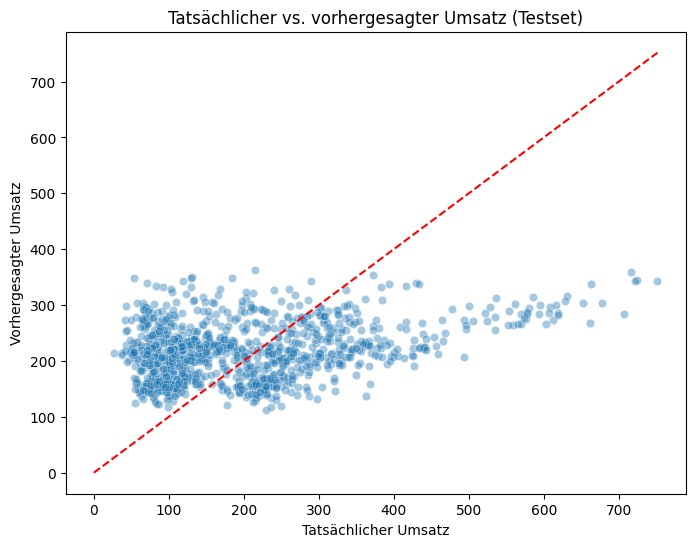

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.scatterplot(x=test[target], y=preds, alpha=0.4)
plt.xlabel("Tatsächlicher Umsatz")
plt.ylabel("Vorhergesagter Umsatz")
plt.title("Tatsächlicher vs. vorhergesagter Umsatz (Testset)")
plt.plot([0, test[target].max()], [0, test[target].max()], color='red', linestyle='--')  # Diagonale
plt.show()

🟨 2. Einfluss der Merkmale (Koeffizienten)

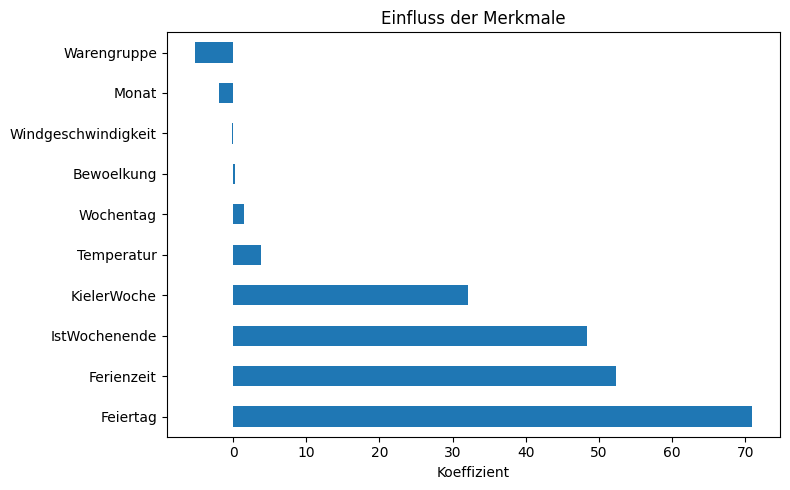

In [12]:
coeffs = pd.Series(model.coef_, index=features)
coeffs.sort_values(ascending=False).plot(kind="barh", figsize=(8, 5), title="Einfluss der Merkmale")
plt.xlabel("Koeffizient")
plt.tight_layout()
plt.show()